# **模型选择、过拟合、欠拟合**

### **训练误差和泛化误差**

**训练误差**：模型在训练数据上的误差    
**泛化误差**：模型在新数据上的误差  
**例子**：根据模考成绩来预测未来的开始分数  
&emsp;在过去的考试中表现很好(训练误差)不代表未来考试一定会好(泛化误差)  
&emsp;学生A通过背书在模考中拿到很好的成绩  
&emsp;学生B知道答案后面的原因

### **验证数据集和测试数据集**

**验证数据集**：一个用来评估模型好坏的数据集  
&emsp;例如拿出50%的训练数据  
&emsp;不要和训练数据混在一起  
**测试数据集**：只用一次的数据集  
&emsp;如未来的考试 
&emsp;我出价房子的实际成交价  
&emsp;用在Kaggle私有排行榜中的数据集

### **K-则交叉验证**

在没有足够多的数据时使用  
算法：  
&emsp;将训练数据分成K块  
&emsp;使用第i块作为沿着数据集，其余的作为训练数据集  
&emsp;报告K个验证集的误差的平均  
常用：K=5或10

### **过拟合和欠拟合**

|     | 简单 | 复杂 |  
|:---:|:---:|:---:|
|__低__|正常|欠拟合|
|__高__|过拟合|正常|

### **模型容量**

拟合各种函数的能力  
低容量的模型难以拟合训练数据  
高容量的模型可以记住所有训练数据  

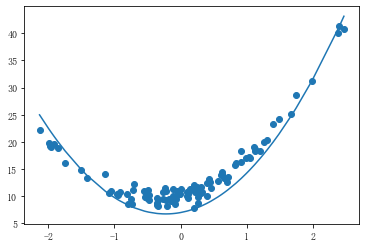

In [2]:
import numpy as np
import matplotlib.pyplot as plt
lr = 0.01     # 学习率
m = 100       # 数据数量
epochs = 100  # 迭代次数
np.random.seed(10)
theta = np.random.randn(3, 1)                      # 随机初始化权重，符合正太分布
x = np.sort(np.random.randn(m, 1), axis=0)         # 生成随机横坐标，服从正太分布，相当与对横坐标做归一化处理
x_c = np.c_[np.ones_like(x), x, x**2]              # 在数据前和后，添加数据
y = 4 * x ** 2 + 3 * x + 10 + np.random.randn(m, 1)  # 生成纵坐标
# 梯度下降
for _ in range(epochs):
    gradient = (1 / m) * np.dot(x_c.T, np.dot(x_c, theta) - y)
    theta = theta - lr * gradient

plt.scatter(x, y)
plt.plot(x, theta[2] * x ** 2 + theta[1] * x + theta[0])
plt.show()

### **估计模型容量**

难以在不同种算法之间比较  
&emsp;例如树模型和神经模型  
给定一个模型种类，酱油两个主要因素  
&emsp;参数的个数  
&emsp;参数值的选择范围  

> **VC维**  对于一个分类模型，VC等于一个最大的数据及大小，不管如何定标号，都存在一个模型来对它进行完美分类  

### **数据复杂度**

* 样本个数  
* 每个样本元素个数  
* 时间、空间结构  
* 多样性

# **实现**

### **模型选择、欠拟合和过拟合**

通过多项式来拟合交互地探索这些概念

In [3]:
import math  
import numpy as np  
import torch  
from torch import nn  
from d2l import torch as d2l

给定$x$，**使用以下三阶多项式来生成训练和测试数据的标签：**

**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**

In [4]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [5]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

查看前两个样本

In [6]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.4362],
         [0.9577]]),
 tensor([[1.0000e+00, 4.3619e-01, 9.5129e-02, 1.3831e-02, 1.5082e-03, 1.3158e-04,
          9.5652e-06, 5.9603e-07, 3.2497e-08, 1.5750e-09, 6.8698e-11, 2.7241e-12,
          9.9018e-14, 3.3223e-15, 1.0351e-16, 3.0100e-18, 8.2057e-20, 2.1054e-21,
          5.1020e-23, 1.1713e-24],
         [1.0000e+00, 9.5771e-01, 4.5861e-01, 1.4640e-01, 3.5053e-02, 6.7142e-03,
          1.0717e-03, 1.4663e-04, 1.7553e-05, 1.8679e-06, 1.7889e-07, 1.5575e-08,
          1.2430e-09, 9.1573e-11, 6.2643e-12, 3.9996e-13, 2.3941e-14, 1.3487e-15,
          7.1760e-17, 3.6171e-18]]),
 tensor([5.3210, 5.4583]))

实现一个函数来评估模型在给定数据集上的损失

In [7]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [8]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

将首先使用三阶多项式函数，它与数据生成函数的阶数相同。  
结果表明，该模型能有效降低训练损失和测试损失。  
学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


weight: [[ 5.0015926  1.2491161 -3.4257717  5.527804 ]]


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


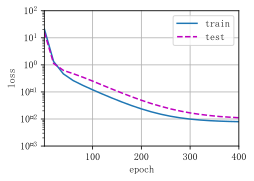

In [9]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### **线性函数拟合(欠拟合)**

线性函数拟合，减少该模型的训练损失相对困难。   
在最后一个迭代周期完成后，训练损失仍然很高。    
当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。   


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


weight: [[3.1703393 4.091946 ]]


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


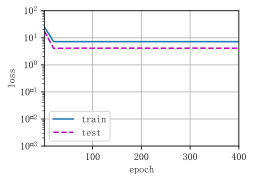

In [10]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### **高阶多项式函数拟合(过拟合)**

使用一个阶数过高的多项式来训练模型。  
在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。  
因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。  
虽然训练损失可以有效地降低，但测试损失仍然很高。  
结果表明，复杂模型对数据造成了过拟合。

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


weight: [[ 4.929341    1.3449973  -3.0607905   5.042341   -1.0516982   1.3236264
  -0.21009946  0.09239627  0.07720691  0.02500712  0.18917057 -0.09392911
  -0.15079659  0.09546178 -0.1927666   0.1794613  -0.15968393  0.17609656
   0.01944207 -0.06802994]]


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


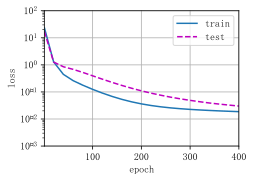

In [12]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=400)